In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from torch import optim

# Dataset

In [3]:
from dataset import get_pytorch_datataset, BATCH_SIZE

df_returns_real, dataset, dataloader, N_ASSETS, WINDOW_SIZE = get_pytorch_datataset()

print(f'\nDataset length: {len(dataset)}')
print(f'Number of assets: {N_ASSETS}')
sample_batch = next(iter(dataloader))
assert sample_batch.size() == (BATCH_SIZE, N_ASSETS, WINDOW_SIZE)
print(f'Sample batch: {sample_batch.size()}')

AAAAAAA data True data\tickers.csv True
Chosen tickers: ['LKOH', 'SBER', 'SBERP', 'VTBR', 'MOEX']
Length before dropping NaNs: 2603
Length after dropping NaNs: 2577

Dataset length: 2451
Number of assets: 5
Sample batch: torch.Size([256, 5, 126])


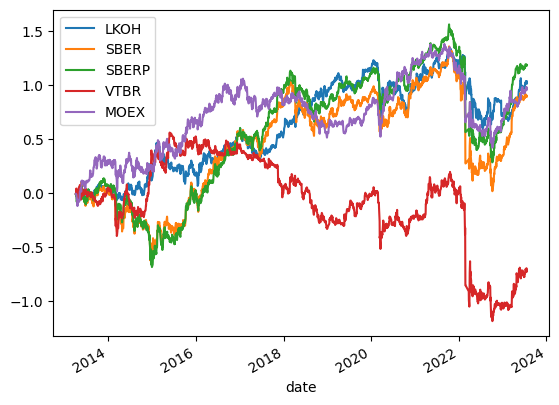

In [4]:
df_returns_real.cumsum().plot()
plt.show()

# GAN GRU


In [5]:
from constants import DEVICE

print(f'Use device: {DEVICE}')

Use device: cpu


In [17]:
from gan_GRU import Discriminator, Generator

assert Discriminator()(next(iter(dataloader))).size() == (BATCH_SIZE,)
assert Generator()(Generator.get_noise(BATCH_SIZE)).size() == next(iter(dataloader)).size()

## Train

In [94]:
from gan_train_loop_GRU import train_gan

N_EPOCHS = 800
LOG_FREQUENCY = 100
SAVE_FREQUENCY = 200

# Define generator and discriminator
discriminator = Discriminator().to(DEVICE)
generator = Generator().to(DEVICE)

# Define the optimizers for generator and discriminator
LR = 0.0002
generator_optimizer = optim.RMSprop(generator.parameters(), lr=LR)
discriminator_optimizer = optim.RMSprop(discriminator.parameters(), lr=LR)

# Train GAN
generator_losses, discriminator_losses_real, discriminator_losses_fake = train_gan(generator, discriminator, generator_optimizer, discriminator_optimizer, dataloader, df_returns_real, n_epochs=N_EPOCHS, log_frequency=LOG_FREQUENCY, save_frequency=SAVE_FREQUENCY, model_prefix='GRU')

C:\Python\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


  0%|          | 0/800 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Generation

## Generate random history

In [95]:
from gan_train_loop import load_gan

generator = Generator().to(DEVICE)
load_gan('GRU', generator, epoch=800)

Load 800 epoch and 2 kernel_size checkpoint


tensor([ 0.2392, -0.1916, -0.0638, -0.0845,  0.0309, -0.0321, -0.0468,  0.1913,
        -0.1102, -0.1666])
tensor([ 0.0150,  0.0626,  0.0499,  0.0495,  0.2414,  0.0218,  0.0176,  0.1053,
        -0.0833, -0.0937])
tensor([-0.0729, -0.0370,  0.0048,  0.0732,  0.0543, -0.0222,  0.0213,  0.1677,
         0.0208,  0.0476])
tensor([-0.1410, -0.0621,  0.1100, -0.1702,  0.0121,  0.0728, -0.0713,  0.1821,
         0.0346,  0.0587])
tensor([ 0.0453, -0.1515,  0.0142, -0.0183, -0.0864,  0.0896,  0.1112,  0.2688,
        -0.0953,  0.1616])
tensor([ 0.0669, -0.3702, -0.0344, -0.0577, -0.1240,  0.0993,  0.2285,  0.2056,
         0.0631,  0.0193])
tensor([ 0.0744, -0.3383,  0.0467, -0.1118,  0.1927,  0.2084,  0.1619,  0.1241,
        -0.0171, -0.0198])
tensor([-0.0306,  0.0864, -0.1079, -0.1907, -0.0954, -0.0754,  0.0601, -0.0005,
        -0.1006, -0.0044])
tensor([-0.0135, -0.1512,  0.1501, -0.2163, -0.1549, -0.0642, -0.1212, -0.1376,
        -0.1277,  0.2036])
tensor([ 0.0087, -0.1089, -0.0205,  0

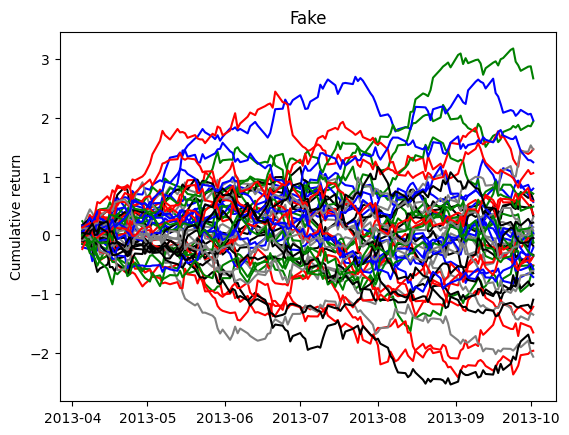

In [96]:
from gan_train_loop_GRU import plot_gan
from generation_GRU import generate_samples


for i in range(10):
    
    gen = generate_samples(generator, dataloader.dataset.assets)
    gen = gen.set_index(df_returns_real.index[:WINDOW_SIZE]).cumsum()
    for asset, color in zip(dataloader.dataset.assets, ['green', 'grey', 'blue', 'red', 'black']):
        # if color == 'green':
        plt.plot(gen[asset], color=color)
        plt.title('Fake')
        plt.ylabel('Cumulative return')



In [97]:
from generation_GRU import generate_fake_returns

df_returns_fake = generate_fake_returns(generator, df_returns_real, seed=0)

dfs.shape = torch.Size([2451, 5, 126])
result.shape = (5, 308826)
shape after merg (2576, 5)


## Plot cumulative real and fake returns

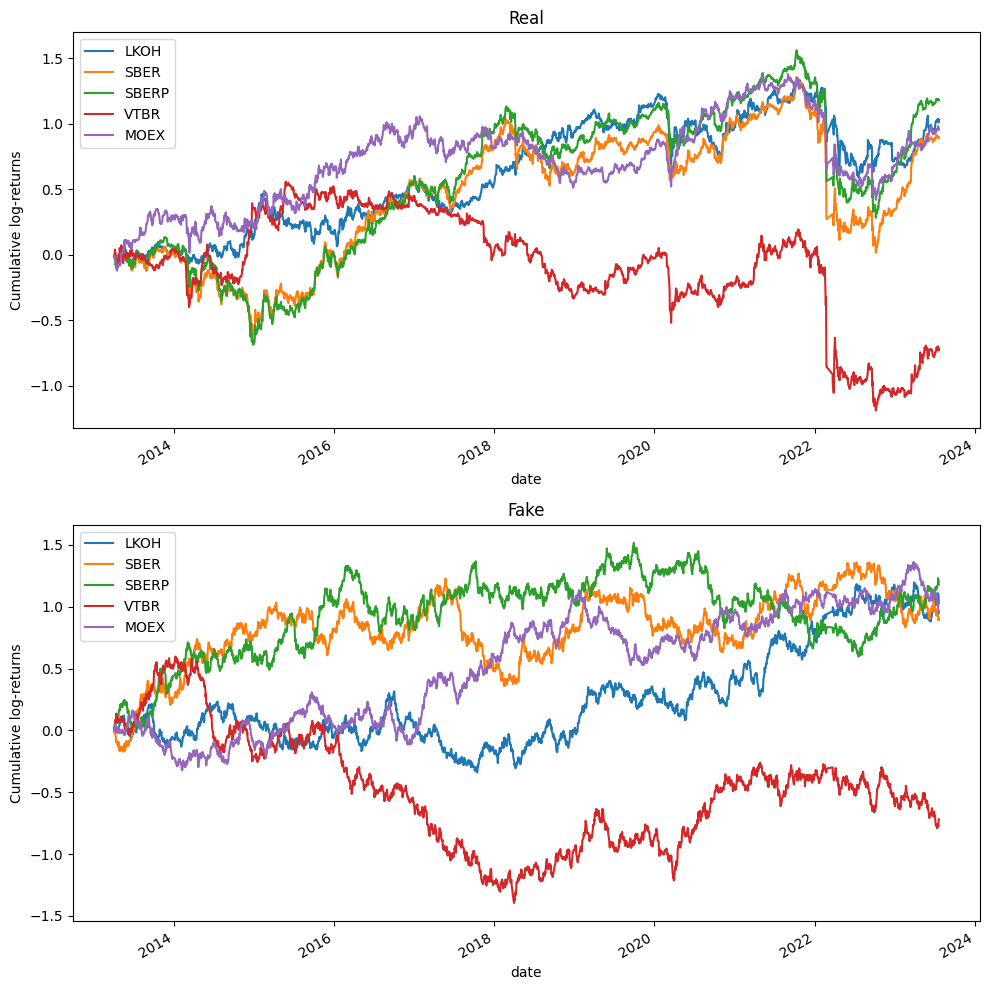

In [98]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

plt.subplot(2, 1, 1)

df_returns_real.cumsum().plot(ax=ax1)
plt.title('Real')
plt.ylabel('Cumulative log-returns')

plt.subplot(2, 1, 2)
df_returns_fake.cumsum().plot(ax=ax2)
plt.title('Fake')
plt.ylabel('Cumulative log-returns')
plt.tight_layout()

plt.show()

## Plot correlation matrix for real and fake returns

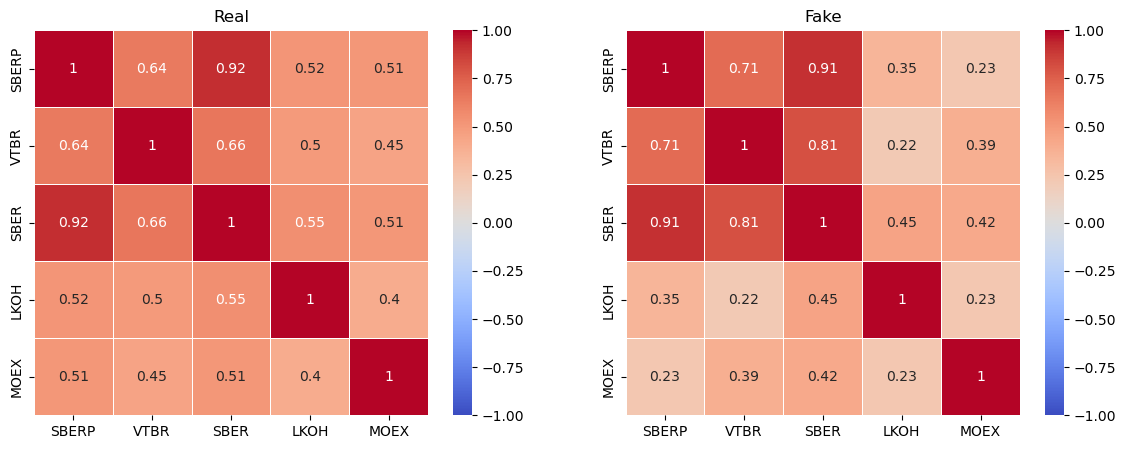

In [195]:
from correlations import plot_correlation_matrix

plt.subplots(1, 2, figsize=(14, 5))

plt.subplot(1, 2, 1)
plot_correlation_matrix(df_returns_real.corr())
plt.title('Real')

plt.subplot(1, 2, 2)
plot_correlation_matrix(df_returns_fake.corr())
plt.title('Fake')

plt.show()

# Plot returns distribution

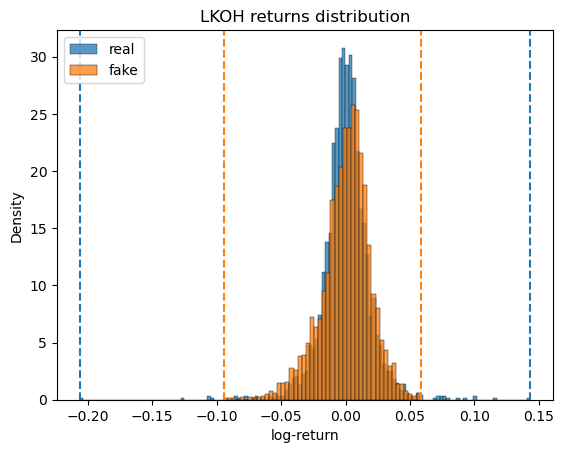

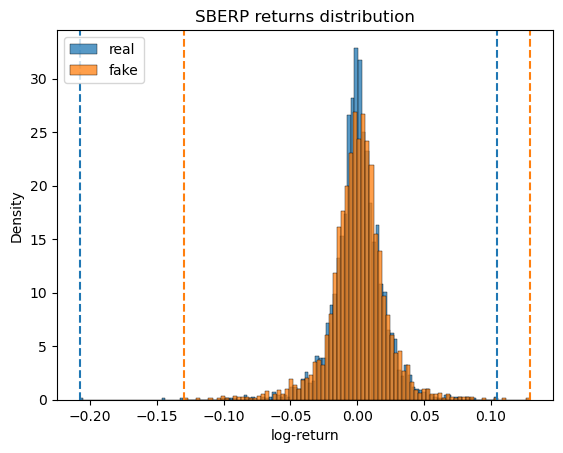

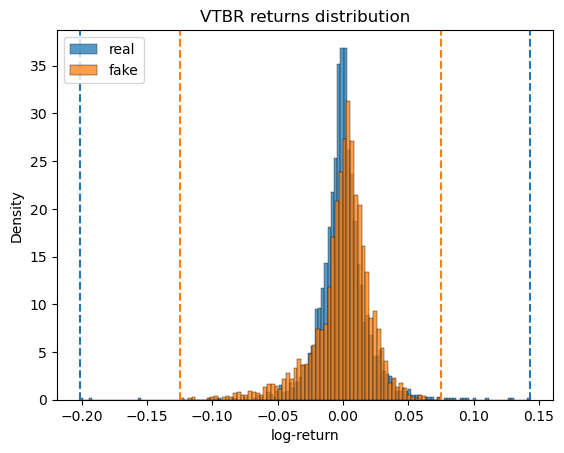

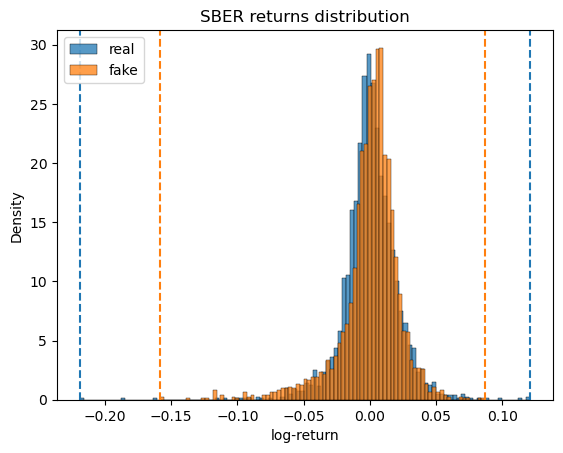

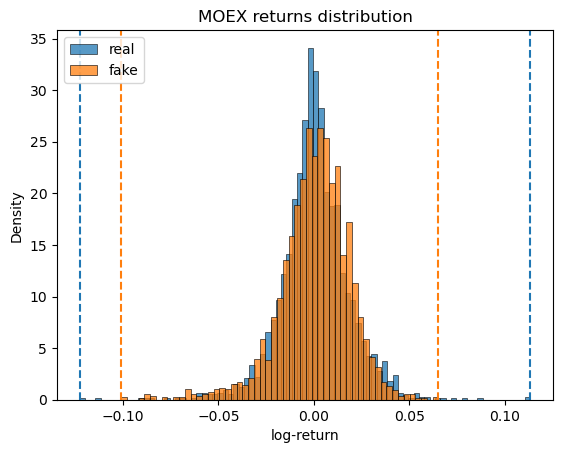

In [185]:
tmp_df_returns_real = df_returns_real[df_returns_real.sum(axis=1) != df_returns_real.sum(axis=1).min()]

for col in df_returns_real.columns:
    # Plot returns distributions
    sns.histplot(tmp_df_returns_real[col], stat='density', label='real')
    sns.histplot(df_returns_fake[col], stat='density', label='fake')

    # Plot real returns bounds
    plt.axvline(tmp_df_returns_real[col].min(), linestyle='dashed', color='C0')
    plt.axvline(tmp_df_returns_real[col].max(), linestyle='dashed', color='C0')

    # Plot fake returns bounds
    plt.axvline(df_returns_fake[col].min(), linestyle='dashed', color='C1')
    plt.axvline(df_returns_fake[col].max(), linestyle='dashed', color='C1')

    plt.xlabel('log-return')
    plt.legend(loc='upper left')
    plt.title(f'{col} returns distribution')
    plt.show()